<a href="https://colab.research.google.com/github/around-star/Deep-Fakes/blob/master/DeepFake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DEEP FAKES

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose, BatchNormalization, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential

In [13]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x = []
for i in range(len(x_train)):
  if (y_train[i] == 0):
    x.append(x_train[i])

x = np.stack(x, axis=0)/255

In [14]:
x.shape

(5923, 28, 28)

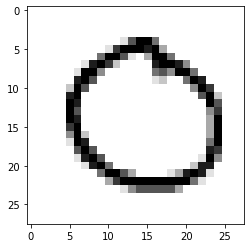

In [15]:
plt.imshow(x[7], cmap='binary')

DISCRIMINATOR

In [16]:
discriminator = Sequential ([
                    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
                    LeakyReLU(),
                    BatchNormalization(),

                    Conv2D(128, 5, strides=2),
                    LeakyReLU(),
                    BatchNormalization(),

                    Conv2D(256, 5, strides=2),
                    LeakyReLU(),
                    BatchNormalization(),

                    Flatten(),
                    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 256)        

GENERATOR

In [17]:
generator = Sequential([
                  Dense(256, activation='relu', input_shape = (50,)),
                  Reshape((1, 1, 256)),

                  Conv2DTranspose(256, 5, activation='relu'),
                  BatchNormalization(),

                  Conv2DTranspose(128, 5, activation='relu'),
                  BatchNormalization(),

                  Conv2DTranspose(64, 5, strides=2, activation='relu'),
                  BatchNormalization(),

                  Conv2DTranspose(32, 5, activation='relu'),
                  BatchNormalization(),

                  Conv2DTranspose(1, 4, activation='sigmoid')

])

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               13056     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 21, 21, 64)       

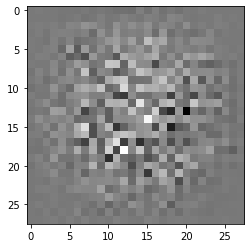

In [18]:
noise = np.random.randn(1,50)
gen_image = generator.predict(noise)[0]
gen_image = np.reshape(gen_image, (28,28))
plt.imshow(gen_image, cmap='binary')

GAN

In [19]:
input_layer = Input(shape = (50,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(input_layer, disc_out)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         2729569   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1027073   
Total params: 3,756,642
Trainable params: 2,728,609
Non-trainable params: 1,028,033
_________________________________________________________________


In [20]:
epochs = 30
batch_size = 128
steps_per_epoch = int (2 * x.shape[0]/batch_size)
print("Steps per epoch : ", steps_per_epoch)

Steps per epoch :  92


TRAINING

In [21]:
for e in range(epochs):

  for step in range(steps_per_epoch):
    X = x[int (batch_size/2)*step : int (batch_size/2)*(step+1)]
    X = np.reshape(X, (X.shape[0], 28, 28, 1))

    noise = np.random.randn(int (batch_size/2), 50)
    gen_examples = generator.predict(noise)

    x_batch = np.concatenate([gen_examples,X], axis=0)
    y_batch = np.array([0] * int (batch_size/2) + [1] * int (batch_size/2))

    indices = np.random.choice(range(batch_size), batch_size, replace = False)

    x_batch = x_batch[indices]
    y_batch = y_batch[indices]

    discriminator.trainable = True
    loss = discriminator.train_on_batch(x_batch, y_batch)
    
    discriminator.trainable = False
    loss2 = gan.train_on_batch(noise, np.ones((int (batch_size/2), 1)))
    


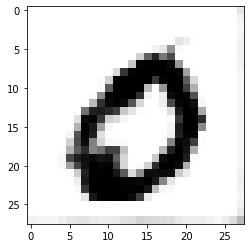

In [24]:
noise = np.random.randn(1,50)
gen_image = generator.predict(noise)[0]
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary')